
# Modelos de classificação de risco para o Covid-19
** **

**Francisco R. D Miranda - Predict / ICMC**

**Lucas R. O. Lopes - Predict / ICMC**

**Março 2022**
** **

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
from sklearn.model_selection import train_test_split
from statsmodels.tools.eval_measures import mse, meanabs

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#**Dados Completos**

In [ ]:
url = "https://github.com/seade-R/dados-covid-sp/raw/66903d66449c7694438451ba553dee874c8417f1/data/casos_obitos_doencas_preexistentes.csv.zip"

df = pd.read_csv(url, sep=';')   

##**Tratamento dos Dados**

In [ ]:
fatores = ['asma', 'cardiopatia', 'diabetes', 'doenca_hematologica', 'doenca_hepatica',
'doenca_neurologica', 'doenca_renal', 'imunodepressao', 'obesidade', 'outros_fatores_de_risco',
'pneumopatia','puerpera','sindrome_de_down']

In [ ]:
# assign 'SIM' = 1 and 'NÃO' = 0 and 'NÃO INFORMADO' = NaN and 'NÃO SABE' = NaN and 'IGNORADO' = NaN in fatores
for f in fatores:
    df[f] = df[f].replace(['SIM', 'NÃO', 'NÃO INFORMADO', 'NÃO SABE', 'IGNORADO'], [1, 0, 0, 0, 0])

#count NaN values for each f in fatores
df_na = df[fatores].isna().sum()

# transformando sexo em dummy 
df = pd.concat([df[fatores + ['idade'] + ['obito']], pd.get_dummies(df['cs_sexo'])], axis=1).dropna()


In [ ]:
print(f'Dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas')
df.head()


Dataset possui 4046548 linhas e 19 colunas


,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,doenca_neurologica,doenca_renal,imunodepressao,obesidade,outros_fatores_de_risco,pneumopatia,puerpera,sindrome_de_down,idade,obito,FEMININO,IGNORADO,INDEFINIDO,MASCULINO
0,0,1,0,0,0,0,0,0,0,0,0,0,0,51.0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,50.0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,17.0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,67.0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,55.0,0,1,0,0,0


In [ ]:
df.to_csv("df.csv")

In [ ]:
df['doenca_hematologica'].value_counts()

0    4043454
1       3094
Name: doenca_hematologica, dtype: int64

In [ ]:
df.shape

(4046548, 19)

##**Análise exploratória dos dados**

Balanceamento da variável resposta

In [ ]:
df['obito'].value_counts(normalize = True)

0    0.965651
1    0.034349
Name: obito, dtype: float64

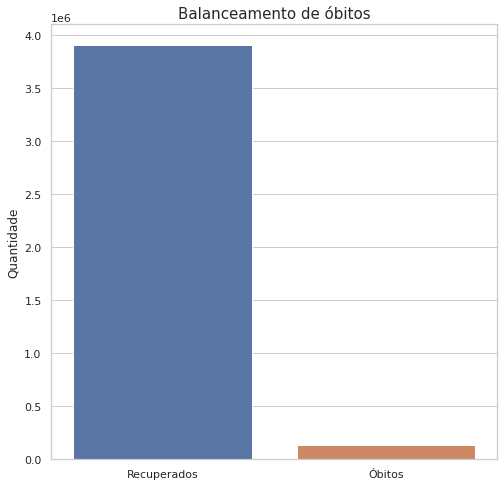

In [ ]:
plt.figure(figsize = (8,8))
plt.title("Balanceamento de óbitos",size = 15)
sns.countplot(data = df, x = 'obito').set_xticklabels(['Recuperados','Óbitos'])
plt.ylabel("Quantidade")
plt.xlabel("")
plt.show()

Contagem de óbitos por cada fator

In [ ]:
df.groupby(by = "obito")[fatores].sum()

,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,doenca_neurologica,doenca_renal,imunodepressao,obesidade,outros_fatores_de_risco,pneumopatia,puerpera,sindrome_de_down
obito,,,,,,,,,,,,,
0,9192,278629,179964,1802,1747,7307,15024,22141,25454,71304,7048,981,738
1,3116,58723,42595,1292,1680,7912,7423,4353,14134,41242,6447,243,440


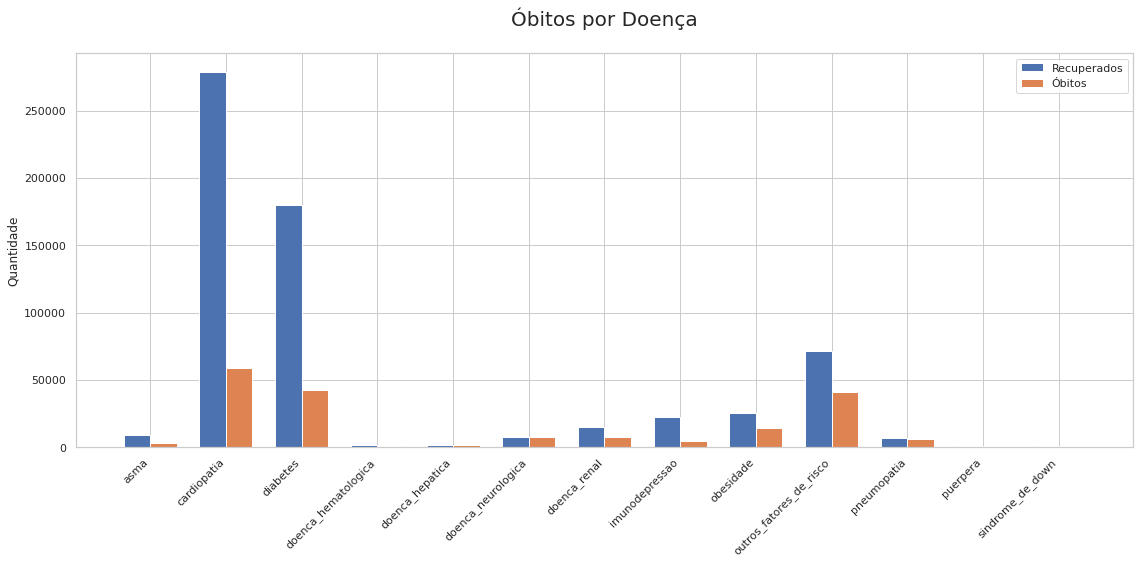

In [ ]:
df_fatores =  df.groupby('obito').sum()[fatores]

x = np.arange(len(fatores))
width = 0.35 
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()

fig.set_figheight(8)
fig.set_figwidth(16)

rects1 = ax.bar(x - width/2, df_fatores.values[0], width, label='Recuperados')
rects2 = ax.bar(x + width/2, df_fatores.values[1], width, label='Óbitos')


ax.set_ylabel('Quantidade')
ax.set_title('Óbitos por Doença\n',size = 20)
ax.set_xticklabels(fatores)
ax.set_xticks(x)
ax.set_xticklabels(fatores,rotation = 45, horizontalalignment = 'right')
ax.legend()

fig.tight_layout()
plt.show()

#**Modelagem**

##Modelo 1: Amostragem Aleatória

In [ ]:
#Importando a amostra aleatória
amos_aleat = pd.read_csv("https://github.com/predict-icmc/covid19/raw/master/leitura-dados/aa.csv")
amos_aleat.head()

,Unnamed: 0,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,doenca_neurologica,doenca_renal,imunodepressao,obesidade,outros_fatores_de_risco,pneumopatia,puerpera,sindrome_de_down,idade,obito,FEMININO,IGNORADO,INDEFINIDO,MASCULINO
0,2157259,0,0,0,0,0,0,0,0,0,0,0,0,0,48.0,0,0,0,0,1
1,12015,0,0,1,0,0,0,0,0,1,0,0,0,0,48.0,1,1,0,0,0
2,1556120,0,0,0,0,0,0,0,0,0,0,0,0,0,46.0,0,1,0,0,0
3,2517316,0,0,0,0,0,0,0,0,0,0,0,0,0,33.0,0,0,0,0,1
4,2039093,0,0,1,0,0,0,0,0,0,0,0,0,0,41.0,0,0,0,0,1


In [ ]:
amos_aleat.groupby(by = 'obito').sum()

,Unnamed: 0,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,doenca_neurologica,doenca_renal,imunodepressao,obesidade,outros_fatores_de_risco,pneumopatia,puerpera,sindrome_de_down,idade,FEMININO,IGNORADO,INDEFINIDO,MASCULINO
obito,,,,,,,,,,,,,,,,,,,
0,58770964920,73,2038,1347,7,13,44,118,188,186,504,45,7,5,1161540.0,15463,1,32,13463
1,2109374524,22,457,345,6,11,53,61,27,108,313,47,6,1,68235.0,458,0,0,583


In [ ]:
diabete = amos_aleat.loc[amos_aleat['diabetes'] == 1]
diabete.head()

,Unnamed: 0,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,doenca_neurologica,doenca_renal,imunodepressao,obesidade,outros_fatores_de_risco,pneumopatia,puerpera,sindrome_de_down,idade,obito,FEMININO,IGNORADO,INDEFINIDO,MASCULINO
1,12015,0,0,1,0,0,0,0,0,1,0,0,0,0,48.0,1,1,0,0,0
4,2039093,0,0,1,0,0,0,0,0,0,0,0,0,0,41.0,0,0,0,0,1
36,28589,0,1,1,0,0,0,0,0,0,0,0,0,0,85.0,1,1,0,0,0
43,2485996,0,1,1,0,0,0,0,0,0,0,0,0,0,79.0,0,0,0,0,1
44,243014,0,0,1,0,0,0,0,0,0,0,0,0,0,50.0,0,0,0,0,1


In [ ]:
diabete.shape

(1692, 20)

In [ ]:
#Verificando o balanceamento da váriavel resposta
amos_aleat['obito'].value_counts(normalize = True)

0    0.9653
1    0.0347
Name: obito, dtype: float64

In [ ]:
#Separado nossas váriaveis em preditoras e resposta
X = amos_aleat.drop(['obito','IGNORADO','INDEFINIDO','MASCULINO','Unnamed: 0'],axis = 1)
y = amos_aleat['obito']

#Vamos dividir em treino e teste
p = 0.2 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = p, random_state = 42)

Ligação LOGIT

\begin{align}
y = logit(x) = ln(\frac{x}{1-x})
\end{align}

In [ ]:
#Adicionado a constante 
x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)
#Criando um modelo da familia binomial com ligação LOGIT
glm_binom_logit = sm.GLM(y_train, x_train, family = sm.families.Binomial())
resultado = glm_binom_logit.fit()
print(resultado.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  obito   No. Observations:                24000
Model:                            GLM   Df Residuals:                    23984
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2329.6
Date:                Mon, 21 Mar 2022   Deviance:                       4659.1
Time:                        06:46:51   Pearson chi2:                 1.88e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [ ]:
np.exp(resultado.params)

const                       0.000962
asma                        4.097652
cardiopatia                 2.383908
diabetes                    1.889540
doenca_hematologica         2.815754
doenca_hepatica             2.446203
doenca_neurologica          3.355716
doenca_renal                3.669791
imunodepressao              1.689338
obesidade                   7.368923
outros_fatores_de_risco     6.135291
pneumopatia                 1.945994
puerpera                   11.157434
sindrome_de_down            1.387616
idade                       1.063858
FEMININO                    0.555221
dtype: float64

Métricas para esse modelo

Para esse módelo vamos utilizar as métricas:





\begin{align}
EQM = \frac{1}{n}\sum_{i=1}^n (\widehat{y_i} - y_i)^2
\end{align}



In [ ]:
print(f' EQM Logit Treino : {mse(y_train,resultado.predict(x_train))}')
print(f' EQM Logit Teste : {mse(y_test,resultado.predict(x_test))}')

 EQM Logit Treino : 0.0254610044643155
 EQM Logit Teste : 0.029105413933212178


Ligação PROBIT

In [ ]:
glm_binom1 = sm.GLM(y_train, x_train, family = sm.families.Binomial(link = sm.genmod.families.links.probit()))
modelo_probit = glm_binom1.fit()
print(modelo_probit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  obito   No. Observations:                24000
Model:                            GLM   Df Residuals:                    23984
Model Family:                Binomial   Df Model:                           15
Link Function:                 probit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2302.3
Date:                Mon, 21 Mar 2022   Deviance:                       4604.6
Time:                        06:46:52   Pearson chi2:                 2.54e+04
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [ ]:
np.exp(modelo_probit.params)

const                      0.031676
asma                       2.043718
cardiopatia                1.557744
diabetes                   1.411390
doenca_hematologica        1.513905
doenca_hepatica            1.702083
doenca_neurologica         2.064191
doenca_renal               2.037126
imunodepressao             1.295071
obesidade                  2.898514
outros_fatores_de_risco    2.704211
pneumopatia                1.549083
puerpera                   3.372227
sindrome_de_down           1.193082
idade                      1.028523
FEMININO                   0.771489
dtype: float64

In [ ]:
print(f' EQM Probit Treino : {mse(y_train,modelo_probit.predict(x_train))}')
print(f' EQM Probit Teste : {mse(y_test,modelo_probit.predict(x_test))}')
print()

 EQM Probit Treino : 0.025285697544527683
 EQM Probit Teste : 0.02891264050814435



Visualização dos Resultados

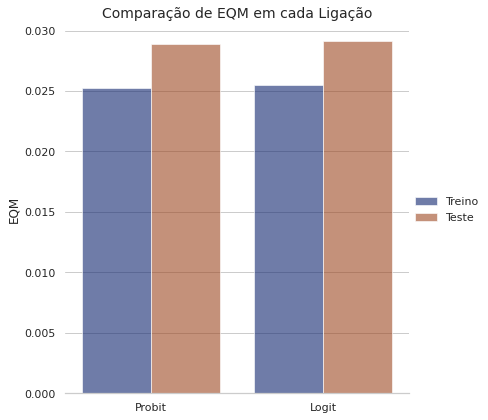

In [ ]:
sns.set_theme(style = "whitegrid")

resultados = {"Ligação":["Probit","Probit","Logit","Logit"],"EQM":[mse(y_train,modelo_probit.predict(x_train)),mse(y_test,modelo_probit.predict(x_test)),
                                                                   mse(y_train,resultado.predict(x_train)),mse(y_test,resultado.predict(x_test))]
              ,"Tipo":["Treino","Teste","Treino","Teste"]}
df = pd.DataFrame(resultados)

g = sns.catplot(
    data= df, kind="bar",
    x="Ligação", y="EQM", hue="Tipo",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
plt.title("Comparação de EQM em cada Ligação",size = 14)
g.set_axis_labels("", "EQM")
g.legend.set_title("")

##Modelo 2 : Amostragem Estratificada

Para essa parte 70% das amostras foram recuperadas e 30% foram a óbito

In [ ]:
amos_estra = pd.read_csv("https://github.com/predict-icmc/covid19/raw/master/leitura-dados/ae.csv")
amos_estra.head()

,Unnamed: 0,asma,cardiopatia,diabetes,doenca_hematologica,doenca_hepatica,doenca_neurologica,doenca_renal,imunodepressao,obesidade,outros_fatores_de_risco,pneumopatia,puerpera,sindrome_de_down,idade,obito,FEMININO,IGNORADO,INDEFINIDO,MASCULINO
0,371454,0,0,0,0,0,0,0,0,0,1,0,0,0,76.0,1,0,0,0,1
1,2441254,0,0,0,0,0,1,0,0,0,0,0,0,0,86.0,1,1,0,0,0
2,2926915,0,0,0,0,0,0,0,0,0,0,0,0,0,42.0,1,0,0,0,1
3,2510490,0,1,1,0,0,0,0,0,0,1,0,0,0,73.0,1,1,0,0,0
4,791890,0,1,1,0,0,0,1,0,0,1,0,0,0,75.0,1,0,0,0,1


In [ ]:
amos_estra['obito'].value_counts(normalize = True)

0    0.7
1    0.3
Name: obito, dtype: float64

In [ ]:
X = amos_estra.drop(['obito','IGNORADO','INDEFINIDO','MASCULINO','Unnamed: 0'],axis = 1)
y = amos_estra['obito']

#Vamos dividir em treino e teste
p = 0.2 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = p, random_state = 42)

Ligação LOGIT

\begin{align}
y = logit(x) = ln(\frac{x}{1-x})
\end{align}

In [ ]:
#Adicionado a constante 
x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)
#Criando um modelo da familia binomial com ligação LOGIT
glm_binom_logit = sm.GLM(y_train, x_train, family = sm.families.Binomial())
resultado = glm_binom_logit.fit()
print(resultado.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  obito   No. Observations:                24000
Model:                            GLM   Df Residuals:                    23984
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8007.4
Date:                Mon, 21 Mar 2022   Deviance:                       16015.
Time:                        06:46:54   Pearson chi2:                 3.63e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [ ]:
np.exp(resultado.params)

const                       0.005489
asma                        2.841808
cardiopatia                 2.548701
diabetes                    1.906007
doenca_hematologica         5.133247
doenca_hepatica            10.730441
doenca_neurologica          5.743278
doenca_renal                3.882356
imunodepressao              1.604123
obesidade                  15.391340
outros_fatores_de_risco     9.808381
pneumopatia                 3.162044
puerpera                   54.108614
sindrome_de_down           39.677712
idade                       1.075692
FEMININO                    0.560651
dtype: float64

Métricas

In [ ]:
print(f' EQM LOGIT Treino : {mse(y_train,resultado.predict(x_train))}')
print(f' EQM LOGIT Teste : {mse(y_test,resultado.predict(x_test))}')
print()

 EQM LOGIT Treino : 0.10163805353020933
 EQM LOGIT Teste : 0.10258561009360949



Ligação PROBIT

In [ ]:
glm_binom1 = sm.GLM(y_train, x_train, family = sm.families.Binomial(link = sm.genmod.families.links.probit()))
modelo_probit = glm_binom1.fit()
print(modelo_probit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  obito   No. Observations:                24000
Model:                            GLM   Df Residuals:                    23984
Model Family:                Binomial   Df Model:                           15
Link Function:                 probit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8053.7
Date:                Mon, 21 Mar 2022   Deviance:                       16107.
Time:                        06:46:55   Pearson chi2:                 9.02e+04
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [ ]:
np.exp(modelo_probit.params)

const                      0.053316
asma                       1.602507
cardiopatia                1.695328
diabetes                   1.439761
doenca_hematologica        2.110246
doenca_hepatica            2.864389
doenca_neurologica         2.343437
doenca_renal               2.051655
imunodepressao             1.294689
obesidade                  4.049775
outros_fatores_de_risco    3.429102
pneumopatia                1.841434
puerpera                   9.515565
sindrome_de_down           5.672523
idade                      1.041616
FEMININO                   0.727943
dtype: float64

In [ ]:
print(f' EQM Probit Treino : {mse(y_train,modelo_probit.predict(x_train))}')
print(f' EQM Probit Teste : {mse(y_test,modelo_probit.predict(x_test))}')

 EQM Probit Treino : 0.10233209054306489
 EQM Probit Teste : 0.10331743647047456


Visualização dos Resultados

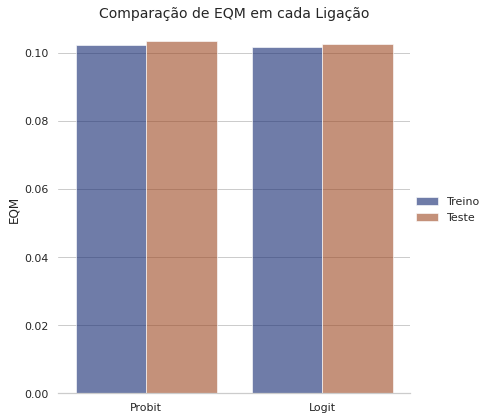

In [ ]:
sns.set_theme(style = "whitegrid")

resultados = {"Ligação":["Probit","Probit","Logit","Logit"],"EQM":[mse(y_train,modelo_probit.predict(x_train)),mse(y_test,modelo_probit.predict(x_test)),
                                                                   mse(y_train,resultado.predict(x_train)),mse(y_test,resultado.predict(x_test))]
              ,"Tipo":["Treino","Teste","Treino","Teste"]}
df = pd.DataFrame(resultados)

h = sns.catplot(
    data= df, kind="bar",
    x="Ligação", y="EQM", hue="Tipo",
    ci="sd", palette="dark", alpha=.6, height=6
)
h.despine(left=True)
plt.title("Comparação de EQM em cada Ligação",size = 14)
h.set_axis_labels("", "EQM")
h.legend.set_title("")